In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pynq import allocate, Overlay,GPIO
from pynq import lib
from pynq.lib.video import *

import cv2 as cv


In [2]:
design = Overlay("Gray_2.bit")
my_dma = design.axi_vdma_0
my_img_ip = design.ImageProcessor_0

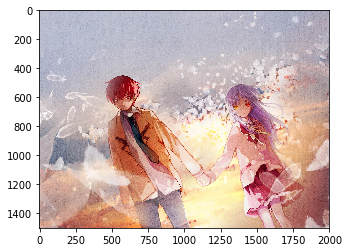

In [3]:
image_path = "../pictures/3.png"
mat_image = cv.imread(image_path,cv.IMREAD_UNCHANGED)
#测试用Ipl格式原图
original_plt_image = Image.open(image_path)
#Mat转PLT
plt_image = Image.fromarray(cv.cvtColor(mat_image,cv.COLOR_BGR2RGB))
#通道变化
rgba_plt_image=plt_image.convert('RGBA')
plt.imshow(rgba_plt_image)
#获取高度宽度
width, height = plt_image.size

In [4]:
#写入内存映射宽高
my_img_ip.write(0x10, height)
my_img_ip.write(0x18, width)
my_img_ip.write(0x00,0x81) # start 必须加不然卡死

my_dma.readchannel.mode=VideoMode(width,height,32)
my_dma.readchannel.start()

my_dma.writechannel.mode=VideoMode(width,height,32)
my_dma.writechannel.start()

img_frame = my_dma.writechannel.newframe()

#申请内存存入输入图像
out_frame = allocate(shape=(height, width, 4), 
                            dtype=np.uint8, cacheable=1)

img_frame[:]=np.array(rgba_plt_image)#original_plt_image#np.array(original_image)
my_dma.writechannel.writeframe(img_frame)

In [5]:
while True:
    if(my_dma.readchannel.activeframe == 0):
        out_frame = my_dma.readchannel.readframe()
        plt_image_out = Image.fromarray(out_frame)
        display(plt_image_out)
        break;
my_dma.readchannel.stop()
my_dma.writechannel.stop()


RuntimeError: Failed to allocate Memory!

In [10]:
del out_frame
del img_frame
del height
del width